# Normalizing Flows

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
import itertools

In [2]:
import flows

In [13]:
import jax
import jax.numpy as jnp
import jax.experimental.stax as stax
import jax.experimental.optimizers as optimizers

In [4]:
from sklearn import datasets, preprocessing

In [57]:
from tomo_challenge import load_data

Found classifier Random
Found classifier ZotBin
Found classifier RandomForest
Found classifier IBandOnly


In [64]:
from zotbin.group import plotfbins

In [58]:
bands='riz'
include_colors=False
include_errors=False

In [59]:
train_file='/media/data2/tomo_challenge_data/ugrizy_buzzard/training.hdf5'
train_data = load_data(train_file, bands, 
                       errors=include_errors,
                       colors=include_colors, array=True)
#train_z = load_redshift(train_file)
print(f'Loaded {len(train_data)} training rows.')

Loaded 5410171 training rows.


/home/dkirkby/DESC/tomo/tomo_challenge/data.py:89: UserWarning: Setting inf (undetected) bands to mag=30
  warnings.warn("Setting inf (undetected) bands to mag=30")


Use r-i, z-i, i as the features:

In [66]:
n_samples= 1000000
X = np.concatenate((np.diff(train_data[:n_samples], axis=1), train_data[:n_samples, 1:2]), axis=1)

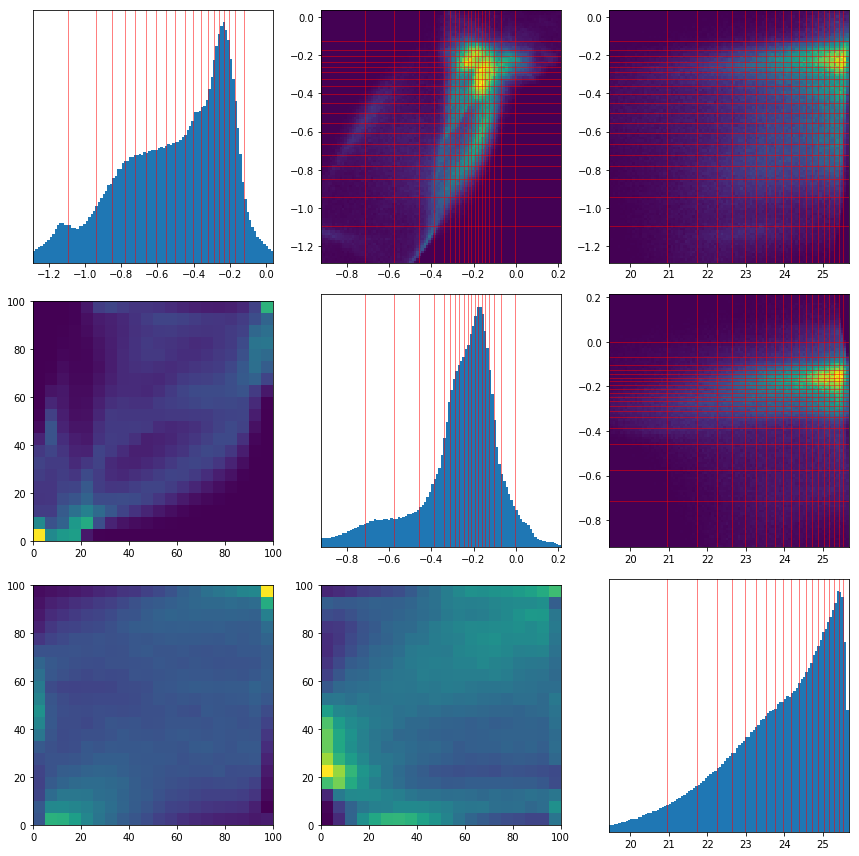

In [67]:
plotfbins(X)

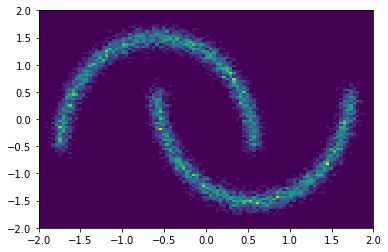

In [45]:
n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = scaler.fit_transform(X)
plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1];

In [68]:
rng, flow_rng = jax.random.split(jax.random.PRNGKey(0))
input_dim = X.shape[1]
num_epochs, batch_size = 300, 100

In [69]:
def get_masks(input_dim, hidden_dim=64, num_hidden=1):
    masks = []
    input_degrees = jnp.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [jnp.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [jnp.transpose(jnp.expand_dims(d1, -1) >= jnp.expand_dims(d0, 0)).astype(jnp.float32)]
    return masks

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=64, num_hidden=1)
    act = stax.Relu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(masks[2].tile(2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun

# Initialize our flow bijection.
bijection_init_fun = flows.Serial(*(flows.MADE(masked_transform), flows.Reverse()) * 5)

# Create direct and inverse bijection functions.
bijection_rng, rng = jax.random.split(rng)
bijection_params, bijection_direct, bijection_inverse = bijection_init_fun(bijection_rng, input_dim)

# Initialize our flow model.
prior_init_fun = flows.Normal()
flow_init_fun = flows.Flow(bijection_init_fun, prior_init_fun)
initial_params, log_pdf, sample = flow_init_fun(flow_rng, input_dim)

In [70]:
def loss(params, inputs):
    return -log_pdf(params, inputs).mean()

@jax.jit
def step(i, opt_state, inputs):
    params = get_params(opt_state)
    gradients = jax.grad(loss)(params, inputs)
    return opt_update(i, gradients, opt_state)

In [71]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

epoch 1


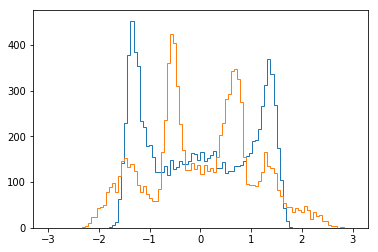

epoch 51


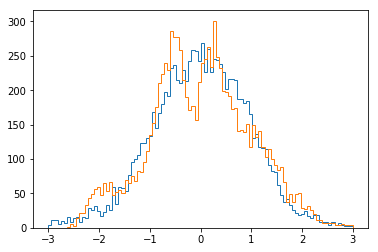

epoch 101


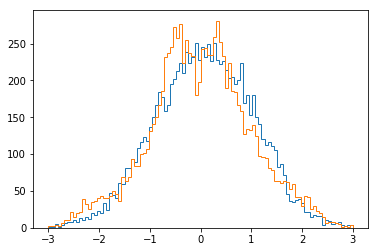

epoch 151


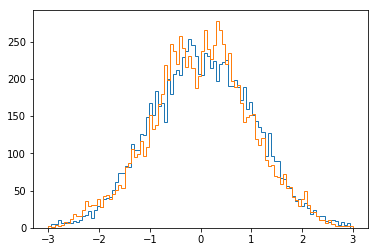

epoch 201


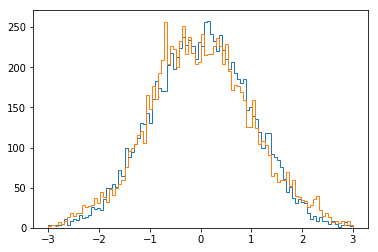

epoch 251


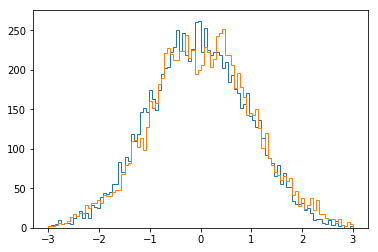

epoch 300


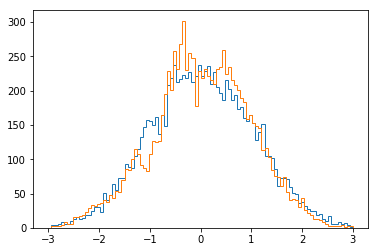

In [56]:
nsample = X.shape[0]
X_trace_in = X.copy()
bins = np.linspace(-3, 3, 101)

opt_state = opt_init(initial_params)
itercount = itertools.count()

for epoch in range(num_epochs):

    permute_rng, rng = jax.random.split(rng)
    X = jax.random.permutation(permute_rng, X)
    for batch_index in range(0, len(X), batch_size):
        opt_state = step(next(itercount), opt_state, X[batch_index:batch_index+batch_size])
    
    if epoch % 50 == 0 or epoch == num_epochs - 1:
        print('epoch', epoch + 1)
        epoch_params = get_params(opt_state)
        
        # Map the input data back through the flow to the prior space.
        X_trace_out, log_det_jac_inv = bijection_direct(epoch_params, X_trace_in)
        for i in range(input_dim):
            plt.hist(X_trace_out[:, i], bins, histtype='step')
        plt.show()
        '''
        # Draw random samples from the prior and pass them through the flow.
        sample_rng, rng = jax.random.split(rng)
        X_syn = sample(rng, epoch_params, nsample)
        # Plot.
        plt.hist2d(X_syn[:, 0], X_syn[:, 1], bins=n_bins, range=plot_range)
        plt.show()
        '''